In [1]:
import everest as ev
import matplotlib.pyplot as pl
import numpy as np
import psffit as pf
import simulateK2
from astropy.stats import median_absolute_deviation as mad
import k2plr
from k2plr.config import KPLR_ROOT
from everest.config import KEPPRF_DIR
import os
import pyfits
from intrapix import PixelFlux
from scipy.optimize import fmin_powell
from tqdm import tqdm
from everest.math import SavGol, Scatter, Downbin

%matplotlib inline

In [12]:
ID = 202072978
# ID = 205998445
# ID = 201367065
client = k2plr.API()
star = client.k2_star(ID)
tpf = star.get_target_pixel_files(fetch = True)[0]
ftpf = os.path.join(KPLR_ROOT, 'data', 'k2', 'target_pixel_files', '%d' % ID, tpf._filename)
with pyfits.open(ftpf) as f:
    xpos = f[1].data['pos_corr1']
    ypos = f[1].data['pos_corr2']
    rfpix = f[1].data['flux']
    rferr = f[1].data['flux_err']

    for i in range(len(xpos)):
        if abs(xpos[i]) >= 50 or abs(ypos[i]) >= 50:
            xpos[i] = 0
            ypos[i] = 0
        if np.isnan(xpos[i]):
            xpos[i] = 0
        if np.isnan(ypos[i]):
            ypos[i] = 0

xpos = xpos[1000:2000]
ypos = ypos[1000:2000]

motion = np.sqrt(xpos**2 + ypos**2)

targetstar = ev.Everest(ID)

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 202072978.


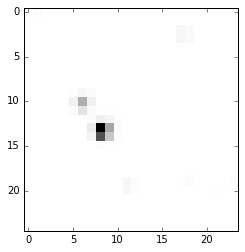

In [120]:
pl.imshow(rfpix[0],interpolation='nearest',cmap='gray_r')

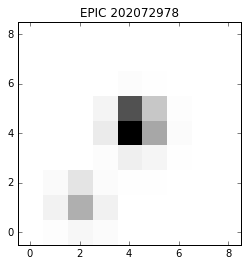

In [121]:
fpix = np.zeros((len(rfpix),9,9))
ferr = np.zeros((len(rfpix),9,9))
for i in range(len(rfpix)):
    fpix[i] = rfpix[i][9:18,4:13]
    ferr[i] = rferr[i][9:18,4:13]

pl.imshow(crop[0],interpolation='nearest',origin='lower',cmap='gray_r');
pl.title('EPIC 202072978');

In [122]:
def PSF(params):
    '''
    Create PSF model from params
    '''
    amp1,amp2,x01,x02,y01,y02,background = params

    cx_1 = [1.,0.,0.]
    cx_2 = [1.,0.,0.]
    cy_1 = [1.,0.,0.]
    cy_2 = [1.,0.,0.]

    sx = 0.5
    sy = 0.5
    rho = 0.0


    model = np.zeros((9,9))
    for i in range(9):
        for j in range(9):
            model[i][j] = PixelFlux(cx_1, cy_1, [amp1], [x01-i], [y01-j], [sx], [sy], [rho]) + \
                          PixelFlux(cx_2, cy_2, [amp2], [x02-i], [y02-j], [sx], [sy], [rho]) + \
                          background
    return model

In [201]:
def Residuals(params):
    '''

    '''

    amp1,amp2,x01,x02,y01,y02,background = params
    # index = self.index
    '''
    # constrain parameter values
    if sx > 1 or sx < 0:
        return 1.0e30
    if sy > 1 or sy < 0:
        return 1.0e30

    if rho >= 1 or rho <= -1:
        return 1.0e30
    '''
    if ((4.5 - x01)**2 + (4.5 - y01)**2) > 5:
        return 1.0e30
    if ((1. - x02)**2 + (2. - y02)**2) > 5:
        return 1.0e30
    
    # Reject negative values for amplitude and position
    for elem in [amp1,amp2,x01,x02,y01,y02]:
        if elem < 0:
            return 1.0e30
    
    PSFfit = PSF(params)

    # sum squared difference between data and model
    PSFres = np.nansum(((fpix[index] - PSFfit)) ** 2)

    # print("R = %.2e, x1 = %.2f, x2 = %.2f, y1 = %.2f, y2 = %.2f, sx = %.2f, sy = %.2f, rho = %.2f, a1 = %.2f, a2 = %.2f, b = %.2e" % \
    #      (PSFres, x01, x02, y01, y02, sx, sy, rho, amp1, amp2,background))

    return PSFres

In [202]:
def FindSolution(guess, index=100):
    '''
    Minimize residuals to find best PSF fit for the data
    '''

    print("Calculating model...")
    answer, chisq, _, iter, funcalls, warn = fmin_powell(Residuals, guess, xtol = 0.0001, ftol = 0.0001,
                                                         disp = False, full_output = True)

    bic = chisq + len(answer) * np.log(len(fpix))

    print("Parameters found!")

    return answer

In [227]:
amp = [80000.0,25000.0]
x0 = [4.5,1.3]
y0 = [4.2,2.5]
sx = [.5]
sy = [.5]
rho = [0.01]
background = [350]

guess = np.concatenate([amp,x0,y0,background])

In [228]:
# fit = pf.PSFFit(fpix,ferr)

answer = FindSolution(guess)
print(guess)
print(answer)

Calculating model...


KeyboardInterrupt: 

In [229]:
# model = PSF(answer)
guessmodel = PSF(guess)

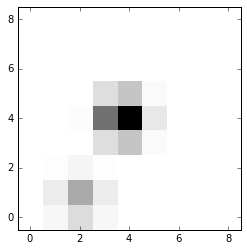

In [230]:
pl.imshow(guessmodel,interpolation='nearest',origin='lower',cmap='gray_r')

In [231]:
fmodel = np.zeros((len(guess)))
for i,v in enumerate(guess):
    if i==1:
        fmodel[i] = 0
    else:
        fmodel[i] = v
mPSF = PSF(fmodel)
mPSF.shape

(9, 9)

In [244]:
cr = np.zeros((9,9))
for i in range(9):
    for j in range(9):
        cr[i][j] = 1 - mPSF[i][j] / guessmodel[i][j]

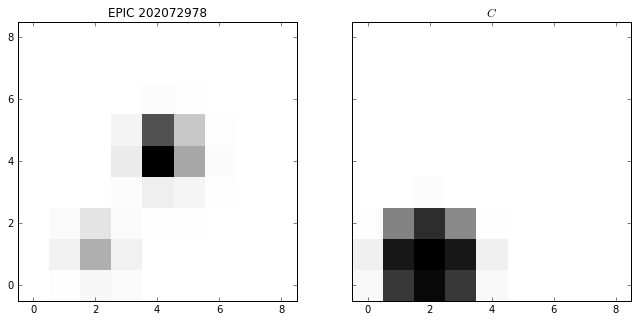

In [245]:
fig, ax = pl.subplots(1,2,sharey = True, figsize = (11,5))
ax[0].imshow(crop[0],interpolation='nearest',origin='lower',cmap='gray_r');
ax[1].imshow(cr,interpolation='nearest',origin='lower',cmap='gray_r');

ax[0].set_title('EPIC 202072978');
ax[1].set_title(r'$C$');
# pl.savefig('cr.eps', format='eps', dpi=250)

# Raw CDPP

In [74]:
def rawcdpp_sim(mag):
    mask = []
    motion = 0
    rmswin = 13
    svgwin = 49
    path = 'stars/larger_aperture/mag' + str(mag) + 'motion' + str(motion) + '.npz'
    
    fpix = np.load(path)['fpix']

    fpix_rs = fpix.reshape(len(fpix),-1)
    flux = np.sum(fpix_rs,axis=1)
    
    flux_savgol = SavGol(np.delete(flux, mask), win = svgwin)
    if len(flux_savgol):
        return Scatter(flux_savgol / np.nanmedian(flux_savgol), remove_outliers = True, win = rmswin)
    else:
        return np.nan

In [75]:
simset = [10,11,12,13,14]
simraw = []
for v in simset:    
    simraw.append(rawcdpp_sim(v))
    
simraw

[148.84459972601923,
 360.79359314286069,
 1012.067496266738,
 2390.2215402170295,
 5638.9436976616871]

In [51]:
def rawcdpp(ID):

    client = k2plr.API()
    star = client.k2_star(ID)
    tpf = star.get_target_pixel_files(fetch = True)[0]
    ftpf = os.path.join(KPLR_ROOT, 'data', 'k2', 'target_pixel_files', '%d' % ID, tpf._filename)
    with pyfits.open(ftpf) as f:
        rfpix = f[1].data['flux']
        rferr = f[1].data['flux_err']
        raw = f[1].data['raw_cnts']
        
    fpix_rs = rfpix.reshape(len(rfpix),-1)
    flux = np.nansum(fpix_rs,axis=1)
    
    mask = np.where(np.isnan(flux) | (flux < 0))

    rmswin = 13
    svgwin = 49
    
    flux_savgol = SavGol(np.delete(flux, mask), win = svgwin)
    if len(flux_savgol):
        return Scatter(flux_savgol / np.nanmedian(flux_savgol), remove_outliers = True, win = rmswin)
    else:
        return np.nan

In [52]:
realset = [206022188,206005223,206006589,206007228,206008049]
realraw = []
for ID in realset:
    realraw.append(rawcdpp(ID))
    
realraw

INFO  [root.fetch()]: Found local file: '/Users/nks1994/.kplr/data/k2/target_pixel_files/206022188/ktwo206022188-c03_lpd-targ.fits.gz'
INFO  [root.fetch()]: Found local file: '/Users/nks1994/.kplr/data/k2/target_pixel_files/206005223/ktwo206005223-c03_lpd-targ.fits.gz'
INFO  [root.fetch()]: Found local file: '/Users/nks1994/.kplr/data/k2/target_pixel_files/206006589/ktwo206006589-c03_lpd-targ.fits.gz'
INFO  [root.fetch()]: Found local file: '/Users/nks1994/.kplr/data/k2/target_pixel_files/206007228/ktwo206007228-c03_lpd-targ.fits.gz'
INFO  [root.fetch()]: Found local file: '/Users/nks1994/.kplr/data/k2/target_pixel_files/206008049/ktwo206008049-c03_lpd-targ.fits.gz'


[2079.1636420336504,
 1584.0003808361898,
 1606.1331517692406,
 1982.6747777329083,
 2081.8410756380126]

In [46]:
new = [206029135,206040730,206022811,206044110]
newraw = []
for ID in new:
    newraw.append(rawcdpp(ID))
    
newx = [10.5,11.5,12.5,13.5]

INFO  [root.fetch()]: Downloading file from: 'http://archive.stsci.edu/pub/k2/target_pixel_files/c3/206000000/29000/ktwo206029135-c03_lpd-targ.fits.gz'
INFO  [root._save_fetched_file()]: Saving file to: '/Users/nks1994/.kplr/data/k2/target_pixel_files/206029135/ktwo206029135-c03_lpd-targ.fits.gz'
INFO  [root.fetch()]: Downloading file from: 'http://archive.stsci.edu/pub/k2/target_pixel_files/c3/206000000/40000/ktwo206040730-c03_lpd-targ.fits.gz'
INFO  [root._save_fetched_file()]: Saving file to: '/Users/nks1994/.kplr/data/k2/target_pixel_files/206040730/ktwo206040730-c03_lpd-targ.fits.gz'
INFO  [root.fetch()]: Downloading file from: 'http://archive.stsci.edu/pub/k2/target_pixel_files/c3/206000000/22000/ktwo206022811-c03_lpd-targ.fits.gz'
INFO  [root._save_fetched_file()]: Saving file to: '/Users/nks1994/.kplr/data/k2/target_pixel_files/206022811/ktwo206022811-c03_lpd-targ.fits.gz'
INFO  [root.fetch()]: Downloading file from: 'http://archive.stsci.edu/pub/k2/target_pixel_files/c3/206000

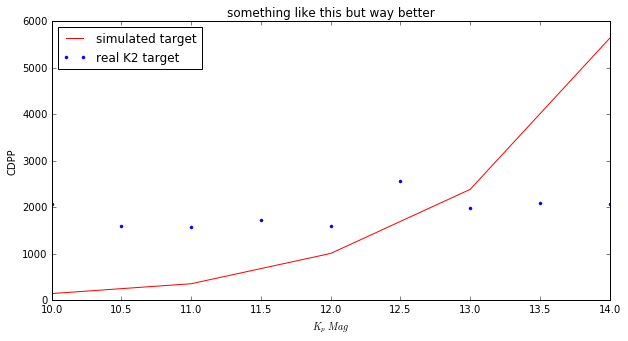

In [77]:
fig = pl.figure(figsize = (10,5))

pl.plot(simset,simraw,'r', label = 'simulated target')
pl.plot(simset,realraw,'b.',label = 'real K2 target')
pl.plot(newx,newraw,'b.')
pl.xlabel(r'$K_p\ Mag$')
pl.ylabel('CDPP')
pl.legend(loc=0)
pl.title('something like this but way better')
# pl.savefig('rawcdpp.eps', format='eps', dpi=250)